##### Model doggy 4 using MobileNet

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv(r'C:\Users\Paula\Desktop\2 SI PROJ\labels.csv')

In [3]:
from keras.preprocessing.image import load_img

labels_dict = {i:j for i,j in zip(labels['id'], labels['breed'])}
classes = set(labels_dict.values())

print('Dog Breed Classes (', (len(classes)), '):')
classes


Dog Breed Classes ( 120 ):


{'affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


Some random dog images from the trainig set


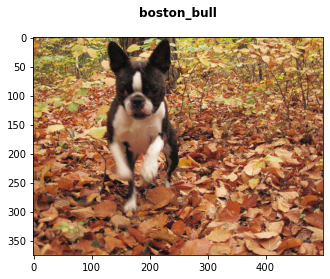

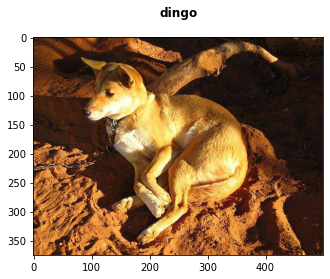

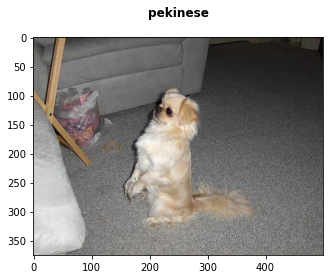

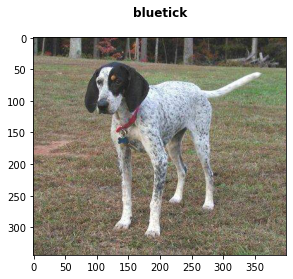

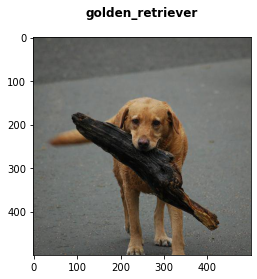

In [4]:
images = [i for i in os.listdir(r'C:\Users\Paula\Desktop\2 SI PROJ\train')]

#for key in labels_dict:
#    print(str(key), '->', labels_dict[key])
print('Some random dog images from the trainig set')

for i in range (0,5):
    img = load_img(r'C:\Users\Paula\Desktop\2 SI PROJ\train/' + images[i])
    plt.imshow(img)
    
    for key in labels_dict:
        if(str(key) == images[i].split('.')[0]):
            #print(str(key), '->', labels_dict[key])
            name = labels_dict[key]
    
    plt.title(name + '\n', fontweight ="bold")
    plt.show()

##### use the same image generator as last time

In [7]:
from keras.preprocessing.image import ImageDataGenerator

img_generator = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,  
                                   zoom_range=0.2,        
                                   horizontal_flip=True) 

training_set  = img_generator.flow_from_directory(r'C:\Users\Paula\Desktop\2 SI PROJ\training_images',
                                                   target_size = (150,150),
                                                   batch_size = 32,
                                                   class_mode = 'categorical')

testing_set   = img_generator.flow_from_directory(r'C:\Users\Paula\Desktop\2 SI PROJ\validation_images',
                                                   target_size=(150,150),
                                                   batch_size=32,
                                                   class_mode='categorical')

Found 8000 images belonging to 120 classes.
Found 2222 images belonging to 120 classes.


In [8]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 6)

##### use fine tunning = a way of applying transfer learning
##### is a process that takes a model that has already been trained for one given task and then tunes the model to make it perform a second similar task
##### MobileNet network it is faster and smaller than other major networks like the next => VGG16

In [9]:
from tensorflow.keras.applications.mobilenet import MobileNet

mobile_model = MobileNet(input_shape=(150, 150,3), include_top=False, weights='imagenet')

mobile_model.trainable = True

print("Number of layers in the MobileNet model: ", len(mobile_model.layers))

Number of layers in the MobileNet model:  86


In [10]:
fine_tune_at = 100
for layer in mobile_model.layers[:fine_tune_at]:
    layer.trainable =  False

#####  create model adding the pre-trained model mobileNet
##### adding GlobalAveragePooling2D layer

In [11]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout

model = Sequential([mobile_model,
                    GlobalAveragePooling2D(),
                    Dropout(rate=0.5),
                    Dense(120, activation='softmax')])


In [12]:
model.compile(optimizer= 'adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
trained_doggy4 = model.fit(training_set, 
                          validation_data=testing_set,
                          epochs=5,
                          verbose=1,
                          callbacks=[early_stopping])

# save the weights
model.save_weights('weights_doggy4.h5')

Epoch 1/5
250/250 [==============================] - 303s 1s/step - loss: 7.0635 - accuracy: 0.0693 - val_loss: 2.5074 - val_accuracy: 0.3893
Epoch 2/5
250/250 [==============================] - 185s 742ms/step - loss: 3.3274 - accuracy: 0.3310 - val_loss: 2.0687 - val_accuracy: 0.4919
Epoch 3/5
250/250 [==============================] - 227s 908ms/step - loss: 2.5380 - accuracy: 0.4277 - val_loss: 2.0750 - val_accuracy: 0.5014
Epoch 4/5
250/250 [==============================] - 447s 2s/step - loss: 2.1677 - accuracy: 0.5028 - val_loss: 1.9970 - val_accuracy: 0.5059
Epoch 5/5
250/250 [==============================] - 447s 2s/step - loss: 1.9722 - accuracy: 0.5401 - val_loss: 1.9745 - val_accuracy: 0.5176


In [14]:
def evaluation_plot (trained):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(trained.epoch, trained.history["loss"], label="Train loss")
    ax[0].plot(trained.epoch, trained.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(trained.epoch, trained.history["accuracy"], label="Train acc")
    ax[1].plot(trained.epoch, trained.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

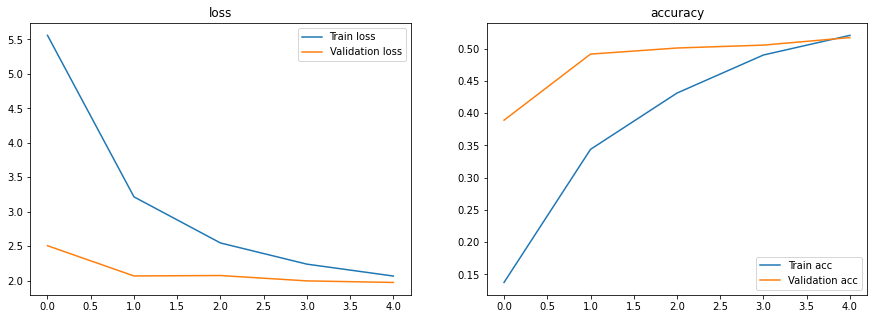

In [15]:
evaluation_plot(trained_doggy4)

In [16]:
# Load weights and evaluate model
model.load_weights('weights_doggy4.h5')

model_doggy1_score = model.evaluate(testing_set)
print("Model doggy4 test loss: ", model_doggy1_score[0])
print("Model doggy4 test accuracy: ", model_doggy1_score[1])

70/70 [==============================] - 96s 1s/step - loss: 1.9768 - accuracy: 0.5252
Model doggy4 test loss:  1.9767591953277588
Model doggy4 test accuracy:  0.5252025127410889


In [18]:
classes= {index:breed for breed,index in training_set.class_indices.items()}
column_names = [classes[i] for i in range(120)]
column_names

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


##### first prediction

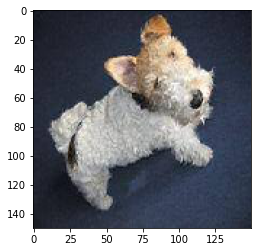

96
scotch_terrier


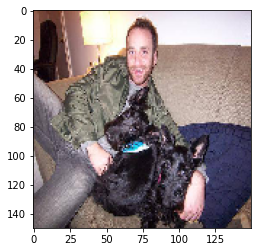

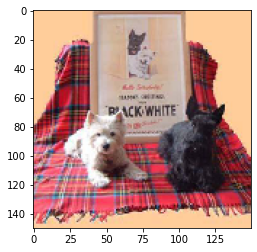

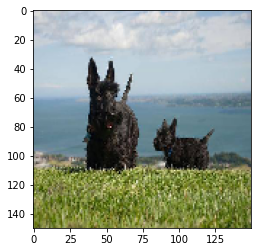

In [19]:
from keras.preprocessing.image import img_to_array

#img_train = load_img(r'C:\Users\Paula\Desktop\2 SI PROJ\train/000bec180eb18c7604dcecc8fe0dba07.jpg',  target_size=(150, 150))
#plt.imshow(img_train)
#plt.show()

img = load_img(r'C:\Users\Paula\Desktop\2 SI PROJ\test\1e4c92e146f1ff2d3c4393a516d47865.jpg',  target_size=(150, 150))
plt.imshow(img)
plt.show()

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
prediction1 = model.predict(x, batch_size=8)

pred_class = np.argmax(prediction1[0])
print(pred_class)
print(column_names[pred_class])


images = [f for f in os.listdir(r'C:\Users\Paula\Desktop\2 SI PROJ\training_images/' + column_names[pred_class])]
images[0]

#plt.imshow(str(images[0]))
for i in range (0,3):
    img = load_img(r'C:\Users\Paula\Desktop\2 SI PROJ\training_images/' + column_names[pred_class] + '/' + images[i],  target_size=(150, 150))
    plt.imshow(img)
    plt.show()


###### second prediction

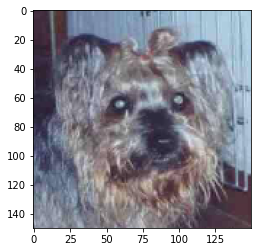

110
toy_poodle


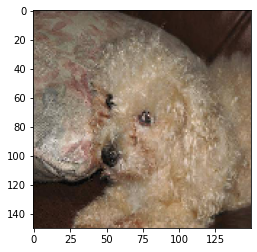

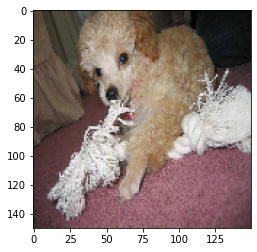

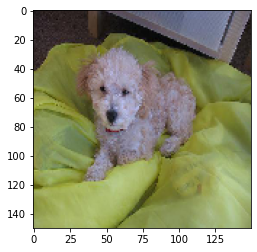

In [25]:
from keras.preprocessing.image import img_to_array

#img_train = load_img(r'C:\Users\Paula\Desktop\2 SI PROJ\train/000bec180eb18c7604dcecc8fe0dba07.jpg',  target_size=(150, 150))
#plt.imshow(img_train)
#plt.show()

img = load_img(r'C:\Users\Paula\Desktop\2 SI PROJ\test\a9ee25d56bd8dbb5b7f340338901a879.jpg',  target_size=(150, 150))
plt.imshow(img)
plt.show()

x = img_to_array(img)
x = np.expand_dims(x, axis=0)
prediction1 = model.predict(x, batch_size=8)

pred_class = np.argmax(prediction1[0])
print(pred_class)
print(column_names[pred_class])


images = [f for f in os.listdir(r'C:\Users\Paula\Desktop\2 SI PROJ\training_images/' + column_names[pred_class])]
images[0]

#plt.imshow(str(images[0]))
for i in range (0,3):
    img = load_img(r'C:\Users\Paula\Desktop\2 SI PROJ\training_images/' + column_names[pred_class] + '/' + images[i],  target_size=(150, 150))
    plt.imshow(img)
    plt.show()
